<a href="https://colab.research.google.com/github/davidivan13/Python-for-Data-Science/blob/main/Text_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

Dalam study case ini kita akan memprediksi review positif dan negatif berdasarkan sentiment dari model klasifikasi logistic regression

**Import necessary libraries**

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings('ignore')


**Import the training dataset**

In [2]:
#importing the training data
imdb_data=pd.read_csv('https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0
5,"For my humanities quarter project for school, ...",1
6,Arguebly Al Pacino's best role. He plays Tony ...,1
7,Being a big fan of Stanley Kubrick's Clockwork...,1
8,I reached the end of this and I was almost sho...,1
9,There is no doubt that Halloween is by far one...,1


**Sentiment count**

In [3]:
#sentiment count
imdb_data['sentiment'].value_counts()

,count
sentiment,
1,25000
0,25000


We can see that the dataset is balanced.

**Spliting the training dataset**

In [4]:
#split the dataset
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


**Text normalization**

In [5]:
import nltk
nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Removing html strips and noise text**

In [6]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

**Removing special characters**

In [7]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text stemming**

In [8]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Removing stopwords**

In [9]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'doesn', 'about', "needn't", "i'm", 'before', 'ours', 'off', "that'll", "couldn't", 'them', 'don', 'or', 'any', 'ma', "won't", 'there', 'wasn', 'again', 'here', 'below', "she'll", 'have', 'no', "we've", 'and', "they'd", 'shan', 'these', 'you', 'does', 'hasn', 'my', "they're", 'those', 'too', 'such', 't', 'having', 'am', 'yourself', "shan't", 'at', 'because', 'few', 'it', 'against', 'should', 'her', 'haven', 'has', 'some', 'the', 'mustn', 'through', "shouldn't", "hadn't", 'we', 'was', 'yourselves', 'our', "you're", 'all', 'up', "it'll", 'under', "she's", 'who', 'only', "wouldn't", 'ain', 'him', 'o', 'both', 'with', "you'll", 'i', 'what', 'when', 'shouldn', 'had', 'by', 'on', 'hadn', "we'll", "hasn't", "haven't", "mightn't", 'their', "don't", "he'll", "it's", 'me', 'wouldn', 'ourselves', 'not', 'then', 'being', 'your', 'down', "doesn't", 'didn', 'as', 'been', 'where', 'its', 'doing', 'hers', 've', 'is', 'an', 'how', 'until', 'during', 'most', 'after', 'that', "should've", 'yours', 'abov

**Normalized train reviews**

In [10]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'famili normal watch local movi simpl reason poorli made lack depth worth timeth trailer nasaan ka man caught attent daughter law daughter took time watch thi afternoon movi exceed expect cinematographi wa veri good stori beauti act awesom jericho rosal wa realli veri good claudin barretto fact despis diether ocampo prove wa effect hi role never thi touch move affect local movi befor imagin cynic like dab eye end movi congratul star cinema way go jericho claudin'

**Normalized test reviews**

In [11]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'thi without doubt funniest curli stoog short ive seen dozen time alway make laugh hilari pantomim sequenc perfect exampl music comedi even peopl dont like knucklehead rememb thi one fondli'

**Bags of words model**

It is used to convert text documents to numerical vectors or bag of words.

In [12]:
#Count vectorizer for bag of words
cv=CountVectorizer(max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6214441)
BOW_cv_test: (10000, 6214441)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [13]:
#Tfidf vectorizer
tv=TfidfVectorizer(max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6214441)
Tfidf_test: (10000, 6214441)


**Labeling the sentiment text**

In [14]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


**Split the sentiment tdata**

In [15]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]
[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]


**Modelling the dataset**

Let us build logistic regression model for both bag of words and tfidf features

In [16]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


**Logistic regression model performane on test dataset**

In [17]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 0 1 ... 0 0 1]
[1 0 1 ... 0 0 1]


**Accuracy of the model**

In [18]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7422
lr_tfidf_score : 0.7414


**Print classification report**

In [19]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      5013
    Negative       0.74      0.75      0.74      4987

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      5013
    Negative       0.74      0.74      0.74      4987

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



**Confusion matrix**

In [20]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3716 1271]
 [1307 3706]]
[[3696 1291]
 [1295 3718]]


**MARI KITA LIHAT REVIEW POSITIVE DAN NEGATIVE DI WORDCLOUD.**

**Word cloud untuk positive review**

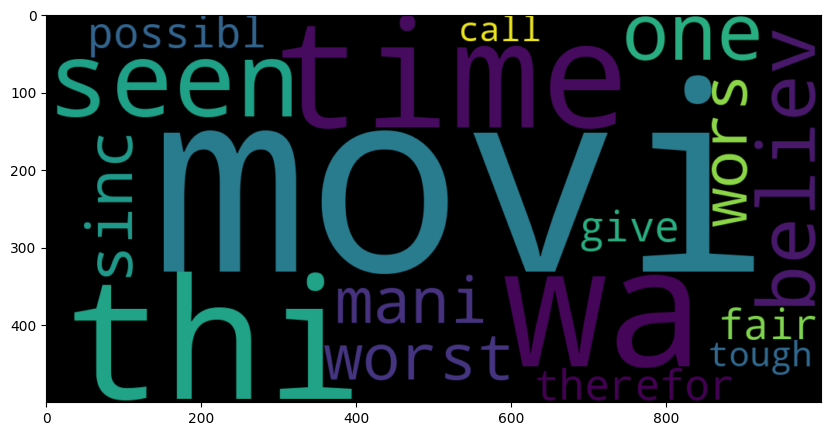

In [21]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

**Word cloud untuk negative review**

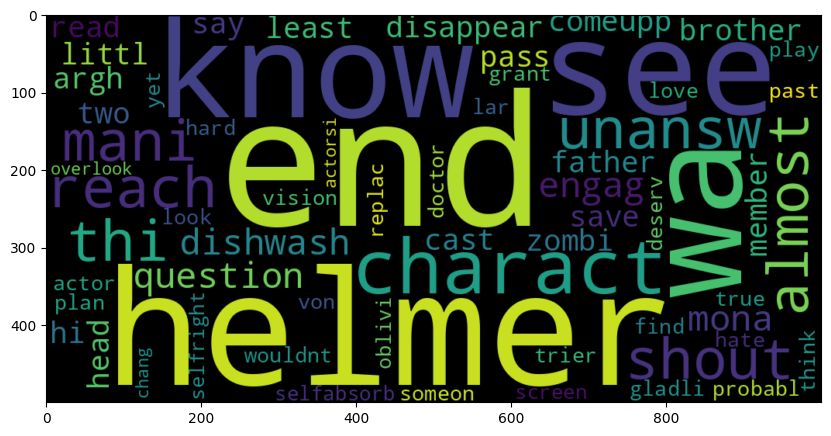

In [22]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()